In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split


MAIN_PATH = '../data/traffic-signs-preprocessed/'

train_data = pd.read_pickle(os.path.join(MAIN_PATH, 'train.pickle'))

train_images, test_images, train_labels, test_labels = train_test_split(
    train_data['features'],
    train_data['labels'],
    train_size=0.8,
    random_state=42
)

labels_lookup = pd.read_csv(os.path.join(MAIN_PATH, 'label_names.csv'))["SignName"]

Lets print some random traffic signs with corresponding labels in NxN box

<Figure size 640x480 with 0 Axes>

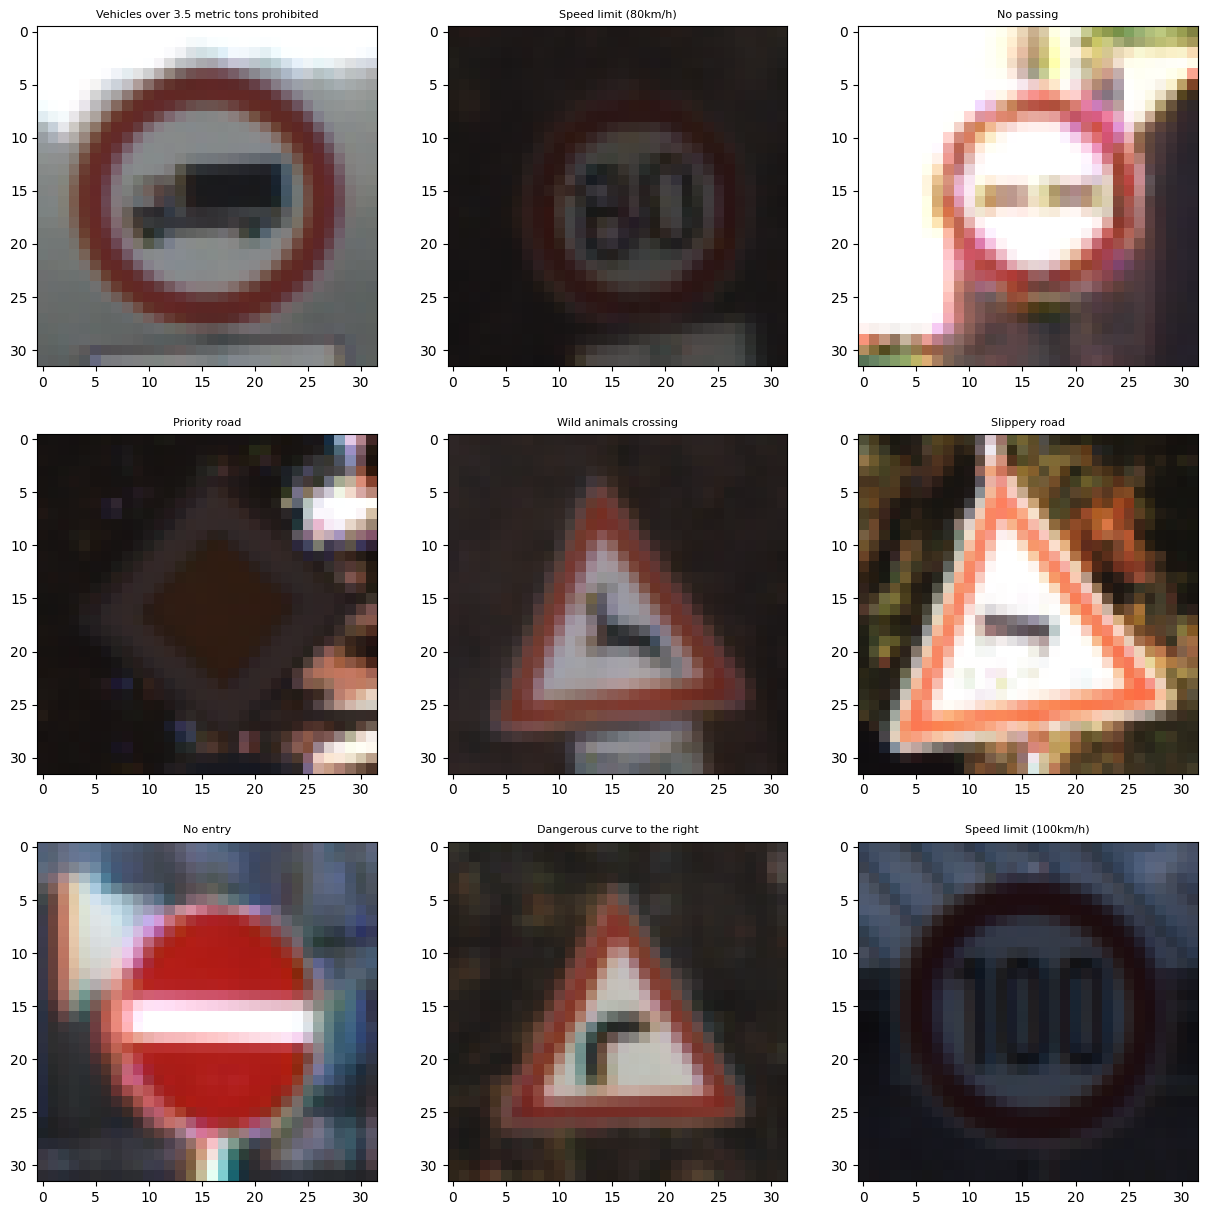

In [2]:
from matplotlib import pyplot as plt
from numpy import random


def print_traffic_signs(images, labels, n=3):
    plt.figure()
    f, axarr = plt.subplots(n, n, figsize=(15, 15))

    for i in range(0, n*n, n):
        indx = [random.randint(0, len(images)-1) for i in range(n)]
        for j in range(n):
            current_index = indx[j]
            current_name = labels_lookup[labels[current_index]]
            axarr[i // n, j].imshow(images[current_index])
            axarr[i // n, j].set_title(current_name, fontsize=8)

    plt.show()

print_traffic_signs(train_images, train_labels, n=3)


**Easy**

In [3]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=200)
flatten_train_images = train_images.reshape(len(train_images), 32*32*3)

model.fit(
    flatten_train_images,
    train_labels
)

Lets predict and measure, we'll use default top-1 accuracy (default accuracy) and f1 score.

In [4]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np


flatten_test_images = test_images.reshape(len(test_images), 32*32*3)

test_prediction = model.predict(
    flatten_test_images
)


print(f"accuracy: {accuracy_score(test_prediction, test_labels)}")
print(f"f1: {f1_score(test_prediction, test_labels, average='weighted')}")

accuracy: 0.9461206896551724
f1: 0.9460285706724844


printing confusion matrix

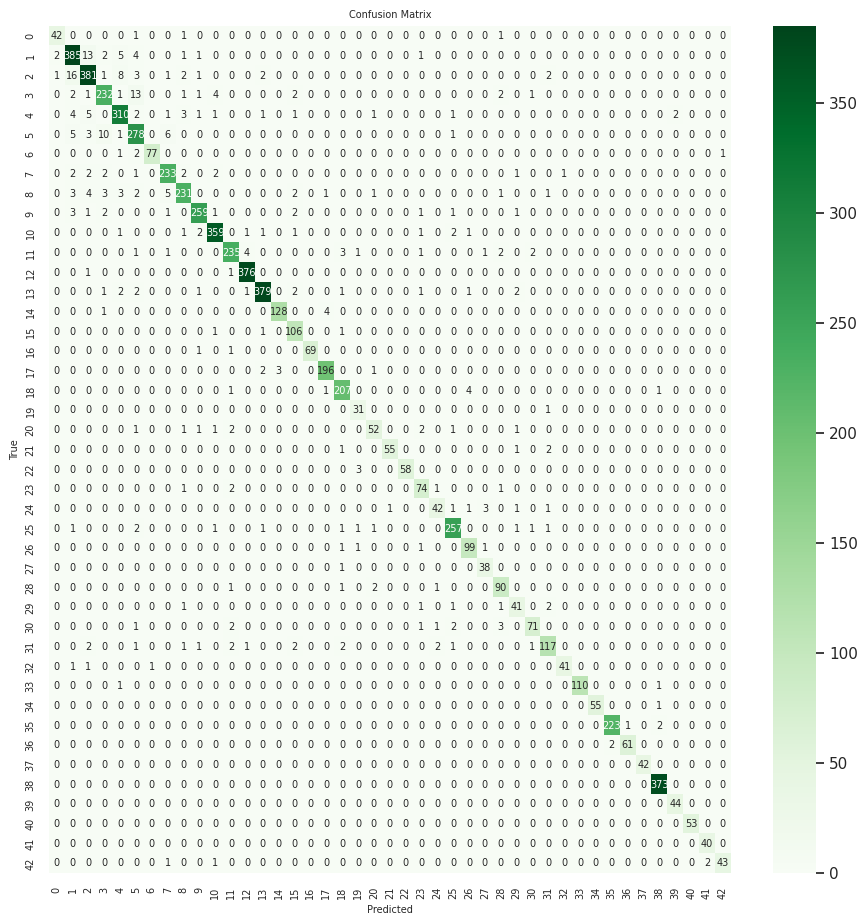

In [5]:
import seaborn as sns


def generate_confusion_matrix(matrix):
    matrix = matrix.astype('float')

    sns.set(rc={'figure.figsize': (11, 11)})
    figure = sns.heatmap(
        matrix,
        annot=True,
        cmap='Greens',
        fmt='.0f',
        annot_kws={"size": 7}
    )

    figure.tick_params(labelsize=7)

    plt.xlabel('Predicted', fontsize=7)
    plt.ylabel('True', fontsize=7)
    plt.title('Confusion Matrix', fontsize=7)
    plt.show()


df_confusion = confusion_matrix(test_prediction, test_labels)
generate_confusion_matrix(df_confusion)


most often there is confusion with 1 and 2 indexes, it's a .. (code is below)

In [6]:
print(labels_lookup[1], labels_lookup[2], sep="\n")

Speed limit (30km/h)
Speed limit (50km/h)


**Medium**

knn

In [7]:
from sklearn.neighbors import KNeighborsClassifier


knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(flatten_train_images, train_labels)


In [8]:
knn_pred = knn_model.predict(flatten_test_images)

In [9]:
print(f"accuracy: {accuracy_score(knn_pred, test_labels)}")
print(f"f1: {f1_score(knn_pred, test_labels, average='weighted')}")

accuracy: 0.8458333333333333
f1: 0.8437323428172209


Naive Bayes classifier for multinomial models

In [10]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(flatten_train_images, train_labels)
nb_pred = nb_model.predict(flatten_test_images)


print(f"accuracy: {accuracy_score(nb_pred, test_labels)}")
print(f"f1: {f1_score(nb_pred, test_labels, average='weighted')}")

accuracy: 0.32600574712643676
f1: 0.29591923112281343


SVM

In [11]:
from sklearn.svm import SVC

# Linear kernel
lc_svm_model = SVC(kernel='linear')
lc_svm_model.fit(flatten_train_images, train_labels)
lc_svm_pred = lc_svm_model.predict(flatten_test_images)


print(f"accuracy: {accuracy_score(lc_svm_pred, test_labels)}")
print(f"f1: {f1_score(lc_svm_pred, test_labels, average='weighted')}")

accuracy: 0.9580459770114943
f1: 0.9579296671787372


In [12]:
# Polynomial kernel
pc_svm_model = SVC(kernel='poly')
pc_svm_model.fit(flatten_train_images, train_labels)
pc_svm_pred = pc_svm_model.predict(flatten_test_images)


print(f"accuracy: {accuracy_score(pc_svm_pred, test_labels)}")
print(f"f1: {f1_score(pc_svm_pred, test_labels, average='weighted')}")

accuracy: 0.7227011494252874
f1: 0.6862354572117074


In [13]:
# Radial Basis Function
rbfc_svm_model = SVC(kernel='rbf')
rbfc_svm_model.fit(flatten_train_images, train_labels)
rbfc_svm_pred = rbfc_svm_model.predict(flatten_test_images)


print(f"accuracy: {accuracy_score(rbfc_svm_pred, test_labels)}")
print(f"f1: {f1_score(rbfc_svm_pred, test_labels, average='weighted')}")

accuracy: 0.8834770114942528
f1: 0.8820881201677507


As we see, the logistic regression shows us the best result, although we can try to change the "max_iter" argument for better perfomance.

The worst result gives a naive bayes approach, I guess, it's because in that approach we assume, that all features r independent, but apparantly, in plain image we have a certain relationship between successive pixels, colors change gradually

**Hard**

in the future we will use only logistic regression, although it showed a slightly worse result than the svm linear kernel, it learns much faster

We'll act like this: consider all classes of pictures, define a variable n, which will indicate the number of pictures from each class.

We'll minimize n, so that the overall quality does not deteriorate too much; for this we'll use image augmentation

In [14]:
unique, counts = np.unique(train_labels, return_counts=True)
counts

array([ 142, 1555, 1616, 1018, 1397, 1312,  304, 1048, 1023, 1067, 1468,
        941, 1473, 1534,  560,  415,  283,  787,  861,  154,  243,  209,
        265,  373,  198, 1089,  430,  158,  382,  200,  301,  551,  174,
        491,  286,  840,  263,  143, 1490,  217,  230,  182,  166])

In [15]:
from collections import defaultdict


def dataset_shrinking(
        threshold: int,
        train_x: np.ndarray,
        train_y: np.ndarray
    ) -> tuple[np.ndarray, np.ndarray]:
    """
    For each class of the original dataset, we'll leave only
    threshold count of images, or less if there were initially fewer
    """

    tmp_data = defaultdict(list)
    for i, x in enumerate(train_x):
        if len(tmp_data[train_y[i]]) < threshold:
            tmp_data[train_y[i]].append(x)

    tmp1_data, tmp1_labels = [], []
    for key, stack in tmp_data.items():
        for item in stack:
            tmp1_data.append(item)
            tmp1_labels.append(key)


    return np.array(tmp1_data), np.array(tmp1_labels)

now, lets write a function which will augmentate images by using code provided at kaggle dataset page

In [16]:
import cv2
import sys

sys.path.append('../data/traffic-signs-preprocessed')

from datasets_preparing import brightness_changing, \
                                rotation_changing, \
                                transformation_brightness_rotation, \
                                rotation_changing



def get_augmented_dataset(
        train_x: np.ndarray,
        train_y: np.ndarray
    ) -> tuple[np.ndarray, np.ndarray]:
    """
    Five different agmentations are applied to each image
    from train_x and corresponding train_y
    """

    def rgb_to_gray_image(img):
        y = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        return cv2.merge((y, y, y))


    def unison_shuffle(a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]


    aug_x, aug_y = [], []

    for i, x in enumerate(train_x):
        aug_x += [
            x.astype(int),
            rgb_to_gray_image(x).astype(int),
            brightness_changing(x).astype(int),
            rotation_changing(x).astype(int),
            transformation_brightness_rotation(x).astype(int)
        ]
        aug_y += [train_y[i]]*5

    aug_images, aug_labels = np.array(aug_x), np.array(aug_y)

    return unison_shuffle(aug_images, aug_labels)





lets train the logistic regression on diffrent counts of images

In [17]:
from tqdm.notebook import tqdm
import warnings

warnings.simplefilter("ignore")


treshold_indexing = [i for i in range(1, 30, 5)]
treshold_indexing += [i for i in range(30, 200, 20)]

report_accuracy, report_f1= [], []


for treshold in tqdm(treshold_indexing):
    minimal_train, minimal_labels = dataset_shrinking(
        treshold,
        train_images,
        train_labels
    )

    aug_images, aug_labels = get_augmented_dataset(
        minimal_train,
        minimal_labels
    )

    model = LogisticRegression(max_iter=200, solver='lbfgs')
    model.fit(aug_images.reshape(len(aug_images), 32*32*3), aug_labels)
    pred = model.predict(flatten_test_images)

    report_accuracy.append(accuracy_score(pred, test_labels))
    report_f1.append(f1_score(pred, test_labels, average='weighted'))

  0%|          | 0/15 [00:00<?, ?it/s]

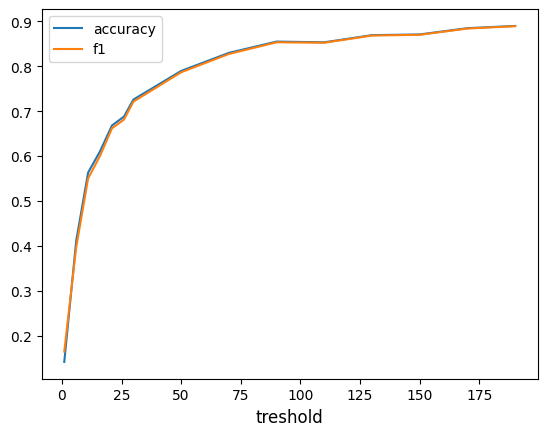

In [18]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.xlabel('treshold', fontsize=12)

plt.plot(treshold_indexing,
         list(zip(report_accuracy, report_f1)),
         label=["accuracy", "f1"]
    )
plt.legend()



**Conclusion**

We compiled a graph of the threshold value for each class of pictures and the metric values obtained when training logistic regression


The most optimal solution is to leave about 75 pictures of each class

If you take a different number of images of different classes, then in the confusion matrix it will be noticeable which classes were predicted worse, For optimal learning, you should take approximately the same number of pictures of all classes


It is likely that rotational augmentations are harmful for signs such as:
"Dangerous curve to the left", "Dangerous curve to the right", "Turn right ahead", "Turn left ahead", "Keep right" and others like these
